In [1]:
import sys
venv_root = '/var/lib/vz/data/c17000697/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')
import os

os.environ["CUDA_DEVICE_VISIBLE"]="0"

In [2]:
import load_caption

#features,texts=load_caption.extract_features_caption(_type='train',save_all=True,pooling=True)
#print(features.shape)
#print(len(texts))

Using TensorFlow backend.


In [3]:
import numpy as np
def load(captions_filename, features_filename):
    features = np.load(features_filename)
    images = []
    texts = []
    with open(captions_filename) as fp:
        for line in fp:
            tokens = line.strip().split()
            images.append(tokens[0])
            texts.append(' '.join(tokens[1:]))
    return features, images, texts
features,images,texts=load('../train.captions.txt','../resnet50-features.train.40k.npy')
#print(features.shape)
#print(len(texts))

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
print(len(texts))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)

# It’s the right time to save the vocabulary so that we can reload it later.
vocab = tokenizer.word_index
vocab['<eos>'] = 0

# add word with id 0
import json
with open('vocab.json', 'w') as fp:
    # save the vocab
    fp.write(json.dumps(vocab))

414113


In [4]:
len(vocab)

22679

In [5]:
import embedding


embedding_weights = embedding.load(vocab, 100, '../embeddings/glove.twitter.27B.100d.filtered.txt')

loading embeddings from "../embeddings/glove.twitter.27B.100d.filtered.txt"


In [9]:
def create_tsv(filename):
    print('loading embeddings from "%s"' % filename, file=sys.stderr)
    with open(filename) as fp,open(filename+'_metadata.tsv','w+') as fp3,open(filename+".tsv",'w+') as fp2:
        for line in fp:
            vector = line.strip().split(' ',1)[1]
            tokens = vector.split(' ')
            for i in range(len(tokens)-2):
                fp2.write(tokens[i]+'\t')
            fp2.write(tokens[len(tokens)-1]+'\n')
            fp3.write(line.strip().split(' ',1)[0]+"\n")
#create_tsv('./embeddings/glove.twitter.27B.100d.filtered.txt')

In [10]:
import numpy as np
import json
import keras
from nltk.tokenize import word_tokenize, sent_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from attention import Attention
from keras.applications.imagenet_utils import preprocess_input

image_input = keras.layers.Input(shape=(2048,))
caption_input = keras.layers.Input(shape=(16,))
noise_input = keras.layers.Input(shape=(16,))

caption_embedding = keras.layers.Embedding(len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = keras.layers.LSTM(256,return_sequences=True)
image_dense = keras.layers.Dense(256, activation='tanh')

attention = Attention()
image_pipeline = image_dense(image_input)
caption_pipeline = attention(caption_rnn(caption_embedding(caption_input)))
noise_pipeline = attention(caption_rnn(caption_embedding(noise_input)))

positive_pair = keras.layers.dot([image_pipeline, caption_pipeline], axes=1)
negative_pair = keras.layers.dot([image_pipeline, noise_pipeline], axes=1)
output = keras.layers.concatenate([positive_pair, negative_pair])

training_model = keras.models.Model(input=[image_input, caption_input, noise_input], output=output)
image_model = keras.models.Model(input=image_input, output=image_pipeline)
caption_model = keras.models.Model(input=caption_input, output=caption_pipeline)

training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 16, 100)      2267900     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________

In [5]:
from keras import backend as K

def custom_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.sum(K.maximum(0., 1. - positive + negative))

def accuracy(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.mean(positive > negative)

In [12]:
training_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])

In [17]:
from keras.callbacks import TensorBoard
from time import time
noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:409113], captions[:409113], noise[:409113]]
Y_train = fake_labels[:409113]
X_valid = [features[-5000:], captions[-5000:], noise[-5000:]]
Y_valid = fake_labels[-5000:]

tensorboard = TensorBoard(log_dir='./logs/{}'.format(time()), histogram_freq=0,write_graph=True, write_images=False)
shuffle_callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda epochs, logs: np.random.shuffle(noise))
nb_epoch = 50

h = training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], nb_epoch=nb_epoch, batch_size=128, verbose=0,callbacks=[shuffle_callback,tensorboard])

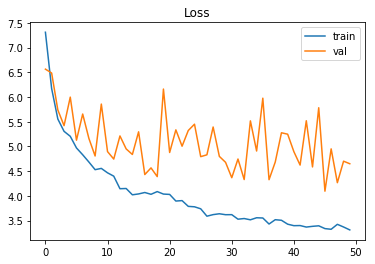

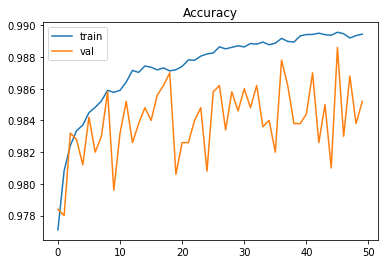

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

x_plt = np.arange(nb_epoch)
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='val')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(x_plt, h.history['accuracy'], label='train')
plt.plot(x_plt, h.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.legend()
plt.show()

In [6]:
#from keras.models import load_model
#training_model.save('training_model.h5')
#caption_model.save('caption_model.h5')
#image_model.save('image_model.h5')
from keras.models import load_model
from attention import Attention
training_model = load_model('training_model.h5',custom_objects={'Attention':Attention,'custom_loss':custom_loss,'accuracy':accuracy})
caption_model = load_model('caption_model.h5',custom_objects={'Attention':Attention,'custom_loss':custom_loss,'accuracy':accuracy})
image_model = load_model('image_model.h5',custom_objects={'Attention':Attention,'custom_loss':custom_loss,'accuracy':accuracy})

In [7]:
#from imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False,pooling="avg")
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = resnet_model.predict(x)
    return np.expand_dims(features.flatten(), axis=0)

In [8]:
#caption_model.save('model.caption')
np.save('caption-representations_2',caption_model.predict(captions))

In [9]:
caption_representations = np.load('caption-representations_2.npy')

In [35]:
def generate_caption(image_filename, n=1,features=False):
    if features: 
        image_representation =image_model.predict(features.reshape((1,2048)))
    else:
        image_representation =image_model.predict(extract_features(image_filename))
    scores = np.dot(caption_representations,image_representation.T).flatten()
    indices = np.argpartition(scores, -n)[-n:]
    indices = indices[np.argsort(scores[indices])]
    print(indices)
    for i in [int(x) for x in reversed(indices)]:
        print(scores[i], texts[i])

        

In [52]:
import numpy as np
import json
from nltk.tokenize import word_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from keras.applications.imagenet_utils import preprocess_input
generate_caption('./data_test/images/00000.jpg')

[126209]
8.381756 a woman eating a donut and pointing at donuts


In [10]:
features,images,texts=load('./data_test/captions.txt','./data_test/image_features.npy')
#sequences = tokenizer.texts_to_sequences(texts)
#captions = pad_sequences(sequences, maxlen=16)


In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
print(len(texts))
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)

# It’s the right time to save the vocabulary so that we can reload it later.
vocab = tokenizer.word_index
vocab['<eos>'] = 0

caption_representations = caption_model.predict(captions)

10000


In [12]:
len(vocab)

22679

In [59]:
import os
import pandas as pd
import numpy as np
import json
from nltk.tokenize import word_tokenize
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

score_matrix = []


last_img = None
with open('./data_test/captions.txt', 'r') as f:
    for i, line in enumerate(f):
        line = line.split(' ', 1)
        image_filename = line[0]
        caption = line[1]

        image_representation = image_model.predict(extract_features('./data_test/images/'+image_filename+'.jpg'))
        scores = np.dot(caption_representations, image_representation.T).flatten()
        score_matrix.append(scores)

        if i % 100 == 0:
            print("{} %".format(i/100))

        captions_.append(caption.rstrip('\n'))
        
score_matrix = np.array(score_matrix)
np.save('matrix.npy',score_matrix)

0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %


In [60]:
texts[score_matrix[69].argmax()]

'outdoors in front of a crowd a man plays an instrument by blowing into pipes he holds up to his face'

In [66]:
generate_caption('./data_test/images/00069.jpg', n=50)

[9512 5030 5424 9021 8458   31 4817 7714 6642 9963 5990 7437  188  757
 9603 2519 6574  721 6510  794 2316 3325 1050 6246 6472  933 6389 5568
 8592 8858 4641 2654 1249 2670 5054 7644 8978 7313 3041 4794  780 1821
 8012 3208 5737 7573 7724 6716 4773 3183]
4.8856077 outdoors in front of a crowd a man plays an instrument by blowing into pipes he holds up to his face
4.718146 an older man in his working uniform handling trash with a woman behind him looking intently at something
4.5107074 a chef preparing hamburgers outside on a grill for patrons walking by
4.1825104 a barbecue tent with a large red umbrella and two male cooks both with white aprons standing over a barbecue grill as a crowd of people pass by
4.062502 a musician wearing a red scarf on his head and holding a microphone wipes his face as he walks away from a smiling dj
3.8246636 a man in an apron smiles as he pokes a frying donut with a little metal stick
3.8187382 young man shaving in the bathroom with razor and shaving crea